# Creating AnyScript Macros

AnyPyTools can create AnyScript macros automatically. Doing so simplifies the process of writing complex macros and makes it easier to do things like parameter studies, Monte Carlo simulation, etc.  

There is a class for every macro command:

In [1]:
from anypytools.macro_commands import (MacroCommand, Load, SetValue, SetValue_random,  Dump, SaveDesign,
                                       LoadDesign, SaveValues, LoadValues, UpdateValues, OperationRun)

### A quick example

The following shows how the to generate a simple macro.

In [2]:
macrolist = [
    Load('Knee.any', defs={'SUBJECT':'"S02"', 'TRIAL':'"T04"'}),
    OperationRun('Main.MyStudy.InverseDynamics'),
    Dump('Main.MyStudy.Output.MaxMuscleActivity'),
] 
macrolist 

[load "Knee.any" -def SUBJECT=---"\"S02\"" -def TRIAL=---"\"T04\"",
 operation Main.MyStudy.InverseDynamics
 run,
 classoperation Main.MyStudy.Output.MaxMuscleActivity "Dump"]

Each macro object will generate the macro commands with the correct syntax.
The macro can be launched using the `start_macro()` method of  the `AnyPyProcess`  object.


In [3]:
from anypytools import AnyPyProcess
app = AnyPyProcess()
app.start_macro(macrolist);


Completed: 1


### Overview of macro commands
The `macro_commands` module have classes for generating many of the standard AnyScipt macro commands.

- `Load(mainfile, defines, paths)`: load command
- `OperationRun(var)`: select operation and run  
- `Dump(var)`: classoperation "Dump"
- `LoadDesign(var, filename)`: classoperation "Load design" 
- `SaveDesign(var, filename)`: classoperation "Save design" 
- `LoadValues(filename)`: classoperation Main "Load Values" 
- `SaveValues(filename)`: classoperation Main "Save Values"
- `UpdateValues()`: classoperation "Update Values"
- `SetValue(var,value)`: classoperation "Set Value" 
- `MacroCommand(macro_string)`: Add abitrary macro string

### Creating many macros

The macro in the previous example would have been easy to write manually. However, in some cases we want to create many macros. Then it is a big advantage to generate them programmatically. 

To generate many macros we need an extra class `AnyMacro` to wrap our macro list.


In [5]:
from anypytools import AnyMacro

macrolist = [
    Load('Knee.any' ),
    OperationRun('Main.MyStudy.InverseDynamics'),
] 

mg = AnyMacro(macrolist)
mg

[['load "Knee.any"', 'operation Main.MyStudy.InverseDynamics', 'run']]

By default `AnyMacro` just behaves as a container for our macro. But has additional attributes that specify how many macros we want. 

In [6]:
mg = AnyMacro(macrolist, number_of_macros = 5)
mg

[['load "Knee.any"', 'operation Main.MyStudy.InverseDynamics', 'run'],
 ['load "Knee.any"', 'operation Main.MyStudy.InverseDynamics', 'run'],
 ['load "Knee.any"', 'operation Main.MyStudy.InverseDynamics', 'run'],
 ['load "Knee.any"', 'operation Main.MyStudy.InverseDynamics', 'run'],
 ['load "Knee.any"', 'operation Main.MyStudy.InverseDynamics', 'run']]

This can also be overidden when calling its `create_macros()` function

In [7]:
mg.create_macros(2)

[['load "Knee.any"', 'operation Main.MyStudy.InverseDynamics', 'run'],
 ['load "Knee.any"', 'operation Main.MyStudy.InverseDynamics', 'run']]

This list of macros can also be passed to the 'start_macro' function to executed in parallel. 

In [8]:
from anypytools import AnyPyProcess

app = AnyPyProcess()
output = app.start_macro(mg.create_macros(100))


Completed: 100


Running many macros is only really useful if the macros are different. Some macros classes, like `SetValue()`, accepts lists of values which it distributes across the generated macros. 

Imagine a list of 5 parameters. We want to create five macros that use these values:

In [9]:
parameter_list = [2.2, 2.5, 2.7, 2.9, 3.1]

mg = AnyMacro(SetValue('Main.MyParameter', parameter_list ))
mg.create_macros(5)

[['classoperation Main.MyParameter "Set Value" --value="2.2"'],
 ['classoperation Main.MyParameter "Set Value" --value="2.5"'],
 ['classoperation Main.MyParameter "Set Value" --value="2.7"'],
 ['classoperation Main.MyParameter "Set Value" --value="2.9"'],
 ['classoperation Main.MyParameter "Set Value" --value="3.1"']]

## A simple parameter study

Let us combine the previous to create a parameter study. We will continue with the simplified knee model where we left off in the previous tutorial. The parameter study will vary the patella tendon length from 2.0cm to 8.0cm, and observe the effect on maximum muscle activity.

First we create a list of patella length parameters. 

In [10]:
patella_tendon_lengths = [
    0.02 + i*0.01 
    for i in range(7)
]
print(patella_tendon_lengths)

[0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]


This list of values is added to the macros with the `SetValue` class. 

In [11]:
macro = [
    Load('Knee.any'),
    SetValue('Main.MyModel.PatellaLigament.DriverPos', patella_tendon_lengths ),
    OperationRun('Main.MyStudy.InverseDynamics'),
    Dump('Main.MyStudy.Output.Abscissa.t'),
    Dump('Main.MyStudy.Output.MaxMuscleActivity'),
    Dump('Main.MyModel.PatellaLigament.DriverPos'),
]

parameter_study_macro = AnyMacro(macro, number_of_macros= len(patella_tendon_lengths) )

We can now run the model and analyze the resulting maximum muscle activity by plotting the data in the `output` variable:

In [12]:
output = app.start_macro(parameter_study_macro)


Completed: 7


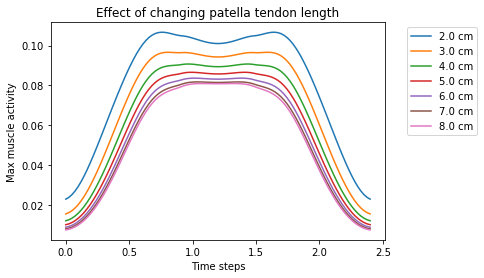

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

for data in output:
    max_activity = data['Main.MyStudy.Output.MaxMuscleActivity']
    time = data['Main.MyStudy.Output.Abscissa.t']
    patella_ligament_length = data['Main.MyModel.PatellaLigament.DriverPos'][0]
    plt.plot(time, max_activity, label='{:.1f} cm'.format(100* patella_ligament_length) )

plt.title('Effect of changing patella tendon length')    
plt.xlabel('Time steps')
plt.ylabel('Max muscle activity')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);
